In [1]:
'''
The logic of this project is to first use a pre-cleaned dataset from online sources, label them based on their folders
convert them to arrays and preprocess those images

then, we train using VGG16 model, from keras to train our model to distinguish between different faces

lastly, we download a pretrained model from the internet, coupled without trained model, we can identify from a video
a person's emotions
'''

"\nThe logic of this project is to first use a pre-cleaned dataset from online sources, label them based on their folders\nconvert them to arrays and preprocess those images\n\nthen, we train using VGG16 model, from keras to train our model to distinguish between different faces\n\nlastly, we download a pretrained model from the internet, coupled without trained model, we can identify from a video\na person's emotions\n"

In [1]:
import os
import numpy as np
from keras.applications.vgg16 import VGG16, preprocess_input
from keras.layers import Dense, GlobalAveragePooling2D, Flatten
from keras.models import Model
from keras.models import Sequential
from keras.preprocessing.image import img_to_array, load_img
from keras.utils import to_categorical
from sklearn.model_selection import train_test_split

datasets = 'datasets'

In [2]:
images = []
labels = []
label_dict = {}
id = 0

# standard way of looping through datasets and label them accordingly
for subdir in os.listdir(datasets):
    subjectpath = os.path.join(datasets, subdir)
    if subdir == '.ipynb_checkpoints':
                continue  # ignores ipynb_checkpoints folder
    if os.path.isdir(subjectpath):
        #all examples online has an ID, so
        label_dict[id] = subdir  
        for filename in os.listdir(subjectpath):
            img_path = os.path.join(subjectpath, filename)
            
            #must be 224, 224 resolution
            image = load_img(img_path, target_size=(224, 224))
            #individual image converted to array
            image = img_to_array(image)
            #using builtin function to preprocess image
            image = preprocess_input(image) 
            images.append(image)
            labels.append(id)
        id += 1

#converts images list to nparray
images = np.array(images)
#encoded labels
labels = to_categorical(np.array(labels))
print(labels)

[[1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 ...
 [0. 0. 1.]
 [0. 0. 1.]
 [0. 0. 1.]]


In [3]:
print(label_dict)

{0: 'rdj', 1: 'scarlett', 2: 'tom'}


In [34]:
x_train, x_test, y_train, y_test = train_test_split(images, labels, test_size=0.99, random_state=42)
#using VGG16 model
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
for layer in base_model.layers:
    layer.trainable = False

In [35]:
#this is how to add a layer
model = Sequential()
model.add(base_model)
model.add(Flatten())
model.add(Dense(1024, activation='relu'))
model.add(Dense(len(label_dict), activation='softmax'))

In [36]:
# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

#train data and validate using test
history = model.fit(x_train, y_train,
                    epochs=20,
                    batch_size=32,
                    validation_data=(x_test, y_test))

Epoch 1/20
1/1 [==============================] - 17s 17s/step - loss: 12.7762 - accuracy: 0.7500 - val_loss: 11.0945 - val_accuracy: 0.6263
Epoch 2/20
1/1 [==============================] - 17s 17s/step - loss: 0.0000e+00 - accuracy: 1.0000 - val_loss: 17.9351 - val_accuracy: 0.6212
Epoch 3/20
1/1 [==============================] - 17s 17s/step - loss: 1.5948e-04 - accuracy: 1.0000 - val_loss: 23.2924 - val_accuracy: 0.6313
Epoch 4/20
1/1 [==============================] - 17s 17s/step - loss: 0.0000e+00 - accuracy: 1.0000 - val_loss: 33.1660 - val_accuracy: 0.5833
Epoch 5/20
1/1 [==============================] - 17s 17s/step - loss: 0.0000e+00 - accuracy: 1.0000 - val_loss: 44.3248 - val_accuracy: 0.5581
Epoch 6/20
1/1 [==============================] - 17s 17s/step - loss: 0.0000e+00 - accuracy: 1.0000 - val_loss: 55.2426 - val_accuracy: 0.5328
Epoch 7/20
1/1 [==============================] - 16s 16s/step - loss: 0.0000e+00 - accuracy: 1.0000 - val_loss: 65.7023 - val_accuracy: 0.

In [37]:
model.save('my_model_1_worst.keras')

In [54]:
from keras.models import load_model

loaded_model = load_model('my_model_25.keras')

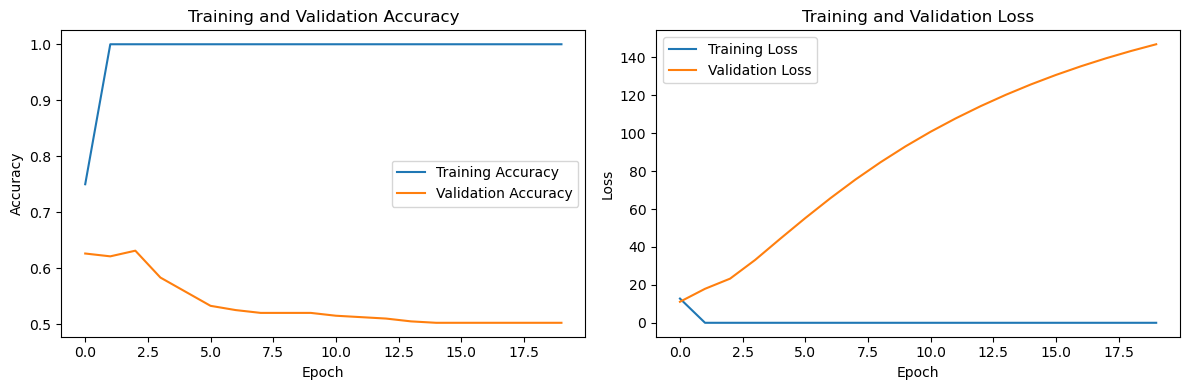

In [39]:
train_accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']
train_loss = history.history['loss']
val_loss = history.history['val_loss']

import matplotlib.pyplot as plt

# Plotting the accuracy
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(train_accuracy, label='Training Accuracy')
plt.plot(val_accuracy, label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

# Plotting the loss
plt.subplot(1, 2, 2)
plt.plot(train_loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

In [55]:
test_path = 'test'
predic = []

for files in os.listdir(test_path):
    if files == '.ipynb_checkpoints':
        continue  # Skip the .ipynb_checkpoints directory
    img_path = os.path.join(test_path, files)
    print(img_path)
    
    #loads the image to 224, 224, converts to arrays and preprocess
    img = load_img(img_path, target_size=(224, 224))
    x = img_to_array(img)
    #this parts expands the shape of the image to make sure nothing goes wrong during preprocessing
    x = np.expand_dims(x, axis=0)
    x = preprocess_input(x)
    
    
    ### here!!!!!!!!!!!!!! ###
    prediction = loaded_model.predict(x)
    
    #using a threshold to label uncategorized images
    threshold = 0.8 
    max_probability = np.max(prediction)
    print(prediction)
    if max_probability < threshold:
        predic.append(np.array([4], dtype=np.int64))
        print(f"Prediction failed {files}: [4] \n")
    else:
        predic.append(np.argmax(prediction, axis=1))
        print(f"Prediction for {files}: {np.argmax(prediction, axis=1)} \n")

test\rdj1.jpg
1/1 [==============================] - 0s 151ms/step
[[9.9991405e-01 0.0000000e+00 8.5883366e-05]]
Prediction for rdj1.jpg: [0] 

test\rdj2.jpg
1/1 [==============================] - 0s 70ms/step
[[8.24242e-13 0.00000e+00 1.00000e+00]]
Prediction for rdj2.jpg: [2] 

test\rdj3.jpg
1/1 [==============================] - 0s 72ms/step
[[2.3327907e-22 0.0000000e+00 1.0000000e+00]]
Prediction for rdj3.jpg: [2] 

test\rdj4.jpg
1/1 [==============================] - 0s 71ms/step
[[2.4280415e-15 0.0000000e+00 1.0000000e+00]]
Prediction for rdj4.jpg: [2] 

test\scarlett1.jpg
1/1 [==============================] - 0s 71ms/step
[[0. 1. 0.]]
Prediction for scarlett1.jpg: [1] 

test\scarlett2.jpg
1/1 [==============================] - 0s 73ms/step
[[0. 1. 0.]]
Prediction for scarlett2.jpg: [1] 

test\scarlett3.jpg
1/1 [==============================] - 0s 73ms/step
[[0. 1. 0.]]
Prediction for scarlett3.jpg: [1] 

test\scarlett4.jpg
1/1 [==============================] - 0s 78ms/step
[[

In [56]:
from sklearn.metrics import classification_report, confusion_matrix
import numpy as np

y_true = np.array([0,0, 0, 0, 1, 1, 1, 1, 2, 2, 2, 2])


y_pred = predic

print(confusion_matrix(y_true, y_pred))
print(classification_report(y_true, y_pred, target_names=['rdj','scarlett','tom']))

[[1 0 3]
 [0 4 0]
 [0 2 2]]
              precision    recall  f1-score   support

         rdj       1.00      0.25      0.40         4
    scarlett       0.67      1.00      0.80         4
         tom       0.40      0.50      0.44         4

    accuracy                           0.58        12
   macro avg       0.69      0.58      0.55        12
weighted avg       0.69      0.58      0.55        12



In [18]:
#now to load a video and split it into frames, apply our model on each frame of the video
import cv2
import time
import numpy as np
from keras.models import load_model
from keras.preprocessing import image
from deepface import DeepFace

video = cv2.VideoCapture('Tom1.mp4')
label_texts = []
start_time = time.time()
while True:
    ret, frame = video.read()
    if not ret:
        break
        
    final_image = cv2.resize(frame, (224, 224))
    final_image = img_to_array(final_image)
    final_image = np.expand_dims(final_image, axis=0)
    final_image = preprocess_input(final_image)
    
    #it doesn't predict faces that aren't front view accurately, due to a small dataset
    prediction = model.predict(final_image)
    threshold = 0.6
    max_probability = np.max(prediction)

    label = np.argmax(prediction, axis=1)[0]
            
    face_analysis = DeepFace.analyze(frame, enforce_detection=False) 
    emotion = face_analysis[0]["dominant_emotion"]
    if max_probability < threshold:
        label_text = f"Unknown, {emotion}"
    else:
        label_text = f"Tom, {emotion}" if label == 2 else f"Unknown, {emotion}"

    label_texts.append(label_text)
        
    cv2.putText(frame, label_text, (10, 30), cv2.FONT_HERSHEY_SIMPLEX, 0.9, (0, 255, 0), 2)
    
    cv2.imshow('Video', frame)
    if cv2.waitKey(1) & 0xFF == ord('q'):
        break
    
end_time = time.time()
total_time = end_time - start_time
total_frames = int(video.get(cv2.CAP_PROP_FRAME_COUNT))
frame_rate = int(video.get(cv2.CAP_PROP_FPS))

video.release()
cv2.destroyAllWindows()
print(f"Total time to process the video: {total_time} seconds")

1/1 [==============================] - 0s 68ms/step


Action: race: 100%|██████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  9.27it/s]


1/1 [==============================] - 0s 71ms/step


Action: race: 100%|██████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  9.31it/s]


1/1 [==============================] - 0s 71ms/step


Action: race: 100%|██████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  9.37it/s]


1/1 [==============================] - 0s 70ms/step


Action: race: 100%|██████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  9.65it/s]

1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 70ms/step


Action: race: 100%|██████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  9.26it/s]


1/1 [==============================] - 0s 70ms/step


Action: race: 100%|██████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  9.24it/s]


1/1 [==============================] - 0s 81ms/step


Action: race: 100%|██████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  9.42it/s]


1/1 [==============================] - 0s 72ms/step


Action: race: 100%|██████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  9.65it/s]


1/1 [==============================] - 0s 74ms/step


Action: race: 100%|██████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  9.40it/s]


1/1 [==============================] - 0s 70ms/step


Action: race: 100%|██████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  9.37it/s]


1/1 [==============================] - 0s 71ms/step


Action: race: 100%|██████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  9.31it/s]


1/1 [==============================] - 0s 70ms/step


Action: race: 100%|██████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.87it/s]


1/1 [==============================] - 0s 97ms/step


Action: race: 100%|██████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  9.01it/s]


1/1 [==============================] - 0s 72ms/step


Action: race: 100%|██████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.85it/s]


1/1 [==============================] - 0s 72ms/step


Action: race: 100%|██████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  9.50it/s]


1/1 [==============================] - 0s 74ms/step


Action: race: 100%|██████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  9.32it/s]


1/1 [==============================] - 0s 71ms/step


Action: race: 100%|██████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  9.41it/s]


1/1 [==============================] - 0s 82ms/step


Action: race: 100%|██████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  7.77it/s]


1/1 [==============================] - 0s 76ms/step


Action: race: 100%|██████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  9.64it/s]


1/1 [==============================] - 0s 70ms/step


Action: race: 100%|██████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  9.21it/s]


1/1 [==============================] - 0s 71ms/step


Action: race: 100%|██████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  9.65it/s]


1/1 [==============================] - 0s 72ms/step


Action: race: 100%|██████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  9.36it/s]


1/1 [==============================] - 0s 70ms/step


Action: race: 100%|██████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.61it/s]


1/1 [==============================] - 0s 70ms/step


Action: race: 100%|██████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  9.26it/s]


1/1 [==============================] - 0s 71ms/step


Action: race: 100%|██████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.89it/s]


1/1 [==============================] - 0s 70ms/step


Action: race: 100%|██████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  9.25it/s]


1/1 [==============================] - 0s 74ms/step


Action: race: 100%|██████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  9.31it/s]


1/1 [==============================] - 0s 70ms/step


Action: race: 100%|██████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  9.39it/s]


1/1 [==============================] - 0s 73ms/step


Action: race: 100%|██████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  9.35it/s]


1/1 [==============================] - 0s 69ms/step


Action: race: 100%|██████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  9.72it/s]


1/1 [==============================] - 0s 71ms/step


Action: race: 100%|██████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  9.24it/s]


1/1 [==============================] - 0s 69ms/step


Action: race: 100%|██████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.74it/s]


1/1 [==============================] - 0s 69ms/step


Action: race: 100%|██████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  9.45it/s]


1/1 [==============================] - 0s 73ms/step


Action: race: 100%|██████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  9.11it/s]


1/1 [==============================] - 0s 72ms/step


Action: race: 100%|██████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  9.52it/s]


1/1 [==============================] - 0s 69ms/step


Action: race: 100%|██████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  9.26it/s]


1/1 [==============================] - 0s 70ms/step


Action: race: 100%|██████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  9.39it/s]


1/1 [==============================] - 0s 71ms/step


Action: race: 100%|██████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  9.50it/s]


1/1 [==============================] - 0s 70ms/step


Action: race: 100%|██████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  9.45it/s]


1/1 [==============================] - 0s 75ms/step


Action: race: 100%|██████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  9.48it/s]


1/1 [==============================] - 0s 71ms/step


Action: race: 100%|██████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  9.01it/s]


1/1 [==============================] - 0s 72ms/step


Action: race: 100%|██████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  9.39it/s]


1/1 [==============================] - 0s 75ms/step


Action: race: 100%|██████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.60it/s]


1/1 [==============================] - 0s 76ms/step


Action: race: 100%|██████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  9.07it/s]


1/1 [==============================] - 0s 78ms/step


Action: race: 100%|██████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.63it/s]


1/1 [==============================] - 0s 76ms/step


Action: race: 100%|██████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.86it/s]


1/1 [==============================] - 0s 75ms/step


Action: race: 100%|██████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  9.08it/s]


1/1 [==============================] - 0s 76ms/step


Action: race: 100%|██████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  9.58it/s]


1/1 [==============================] - 0s 74ms/step


Action: race: 100%|██████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  9.28it/s]


1/1 [==============================] - 0s 74ms/step


Action: race: 100%|██████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  9.34it/s]


1/1 [==============================] - 0s 73ms/step


Action: race: 100%|██████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  9.36it/s]


1/1 [==============================] - 0s 73ms/step


Action: race: 100%|██████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  9.39it/s]


1/1 [==============================] - 0s 72ms/step


Action: race: 100%|██████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  9.43it/s]


1/1 [==============================] - 0s 73ms/step


Action: race: 100%|██████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  9.40it/s]


1/1 [==============================] - 0s 73ms/step


Action: race: 100%|██████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.93it/s]


1/1 [==============================] - 0s 73ms/step


Action: race: 100%|██████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  9.47it/s]


1/1 [==============================] - 0s 75ms/step


Action: race: 100%|██████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  9.25it/s]


1/1 [==============================] - 0s 74ms/step


Action: race: 100%|██████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  9.39it/s]


1/1 [==============================] - 0s 74ms/step


Action: race: 100%|██████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  9.17it/s]


1/1 [==============================] - 0s 74ms/step


Action: race: 100%|██████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  9.35it/s]


1/1 [==============================] - 0s 75ms/step


Action: race: 100%|██████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  9.38it/s]


1/1 [==============================] - 0s 74ms/step


Action: race: 100%|██████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  9.29it/s]


1/1 [==============================] - 0s 77ms/step


Action: race: 100%|██████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  9.38it/s]


1/1 [==============================] - 0s 73ms/step


Action: race: 100%|██████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  9.14it/s]


1/1 [==============================] - 0s 74ms/step


Action: race: 100%|██████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  9.37it/s]


1/1 [==============================] - 0s 74ms/step


Action: race: 100%|██████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  9.12it/s]


1/1 [==============================] - 0s 72ms/step


Action: race: 100%|██████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  9.41it/s]


1/1 [==============================] - 0s 73ms/step


Action: race: 100%|██████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  9.06it/s]


1/1 [==============================] - 0s 74ms/step


Action: race: 100%|██████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  9.22it/s]


1/1 [==============================] - 0s 76ms/step


Action: race: 100%|██████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  9.23it/s]


1/1 [==============================] - 0s 74ms/step


Action: race: 100%|██████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  9.50it/s]


1/1 [==============================] - 0s 77ms/step


Action: race: 100%|██████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  9.26it/s]


1/1 [==============================] - 0s 73ms/step


Action: race: 100%|██████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  9.28it/s]


1/1 [==============================] - 0s 73ms/step


Action: race: 100%|██████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  9.27it/s]


1/1 [==============================] - 0s 78ms/step


Action: race: 100%|██████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  9.29it/s]


1/1 [==============================] - 0s 74ms/step


Action: race: 100%|██████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  7.05it/s]


1/1 [==============================] - 0s 77ms/step


Action: race: 100%|██████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  9.15it/s]


1/1 [==============================] - 0s 75ms/step


Action: race: 100%|██████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  9.31it/s]


1/1 [==============================] - 0s 76ms/step


Action: race: 100%|██████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.86it/s]


1/1 [==============================] - 0s 77ms/step


Action: race: 100%|██████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  9.12it/s]


1/1 [==============================] - 0s 75ms/step


Action: race: 100%|██████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.06it/s]


1/1 [==============================] - 0s 82ms/step


Action: race: 100%|██████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.38it/s]


1/1 [==============================] - 0s 76ms/step


Action: race: 100%|██████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.98it/s]


1/1 [==============================] - 0s 87ms/step


Action: race: 100%|██████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  9.06it/s]


1/1 [==============================] - 0s 75ms/step


Action: race: 100%|██████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.77it/s]


1/1 [==============================] - 0s 75ms/step


Action: race: 100%|██████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.95it/s]


1/1 [==============================] - 0s 78ms/step


Action: race: 100%|██████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.91it/s]


1/1 [==============================] - 0s 77ms/step


Action: race: 100%|██████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  9.04it/s]


1/1 [==============================] - 0s 79ms/step


Action: race: 100%|██████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  9.05it/s]


1/1 [==============================] - 0s 77ms/step


Action: race: 100%|██████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.67it/s]


1/1 [==============================] - 0s 75ms/step


Action: race: 100%|██████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  9.21it/s]


1/1 [==============================] - 0s 77ms/step


Action: race: 100%|██████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.68it/s]


1/1 [==============================] - 0s 77ms/step


Action: race: 100%|██████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  9.25it/s]


1/1 [==============================] - 0s 74ms/step


Action: race: 100%|██████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  9.15it/s]


1/1 [==============================] - 0s 76ms/step


Action: race: 100%|██████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.95it/s]


1/1 [==============================] - 0s 76ms/step


Action: race: 100%|██████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  9.28it/s]


1/1 [==============================] - 0s 74ms/step


Action: race: 100%|██████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.89it/s]


1/1 [==============================] - 0s 80ms/step


Action: race: 100%|██████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  9.18it/s]


1/1 [==============================] - 0s 77ms/step


Action: race: 100%|██████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  9.05it/s]


1/1 [==============================] - 0s 75ms/step


Action: race: 100%|██████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  9.07it/s]


1/1 [==============================] - 0s 75ms/step


Action: race: 100%|██████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.87it/s]


1/1 [==============================] - 0s 76ms/step


Action: race: 100%|██████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  9.20it/s]


1/1 [==============================] - 0s 76ms/step


Action: race: 100%|██████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.65it/s]


1/1 [==============================] - 0s 74ms/step


Action: race: 100%|██████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  9.04it/s]


1/1 [==============================] - 0s 79ms/step


Action: race: 100%|██████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  9.31it/s]


1/1 [==============================] - 0s 78ms/step


Action: race: 100%|██████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.95it/s]


1/1 [==============================] - 0s 74ms/step


Action: race: 100%|██████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  9.28it/s]


1/1 [==============================] - 0s 75ms/step


Action: race: 100%|██████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  9.13it/s]


1/1 [==============================] - 0s 74ms/step


Action: race: 100%|██████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  9.26it/s]


1/1 [==============================] - 0s 73ms/step


Action: race: 100%|██████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  9.14it/s]


1/1 [==============================] - 0s 74ms/step


Action: race: 100%|██████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  9.31it/s]


1/1 [==============================] - 0s 74ms/step


Action: race: 100%|██████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  9.28it/s]


1/1 [==============================] - 0s 75ms/step


Action: race: 100%|██████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.81it/s]


1/1 [==============================] - 0s 74ms/step


Action: race: 100%|██████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  9.20it/s]


1/1 [==============================] - 0s 75ms/step


Action: race: 100%|██████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  9.15it/s]


1/1 [==============================] - 0s 75ms/step


Action: race: 100%|██████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  9.18it/s]


1/1 [==============================] - 0s 75ms/step


Action: race: 100%|██████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.90it/s]


1/1 [==============================] - 0s 77ms/step


Action: race: 100%|██████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.86it/s]


1/1 [==============================] - 0s 81ms/step


Action: race: 100%|██████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  9.21it/s]


1/1 [==============================] - 0s 74ms/step


Action: race: 100%|██████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  9.07it/s]


1/1 [==============================] - 0s 74ms/step


Action: race: 100%|██████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  7.84it/s]


1/1 [==============================] - 0s 85ms/step


Action: race: 100%|██████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.61it/s]


1/1 [==============================] - 0s 76ms/step


Action: race: 100%|██████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.68it/s]


1/1 [==============================] - 0s 75ms/step


Action: race: 100%|██████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  9.12it/s]


1/1 [==============================] - 0s 79ms/step


Action: race: 100%|██████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.87it/s]


1/1 [==============================] - 0s 74ms/step


Action: race: 100%|██████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  9.07it/s]


1/1 [==============================] - 0s 76ms/step


Action: race: 100%|██████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.94it/s]


1/1 [==============================] - 0s 77ms/step


Action: race: 100%|██████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.94it/s]


1/1 [==============================] - 0s 78ms/step


Action: race: 100%|██████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.82it/s]


1/1 [==============================] - 0s 78ms/step


Action: race: 100%|██████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.58it/s]


1/1 [==============================] - 0s 77ms/step


Action: race: 100%|██████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  9.14it/s]


1/1 [==============================] - 0s 75ms/step


Action: race: 100%|██████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  9.03it/s]


1/1 [==============================] - 0s 77ms/step


Action: race: 100%|██████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  9.12it/s]


1/1 [==============================] - 0s 76ms/step


Action: race: 100%|██████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  9.13it/s]


1/1 [==============================] - 0s 75ms/step


Action: race: 100%|██████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.94it/s]


1/1 [==============================] - 0s 77ms/step


Action: race: 100%|██████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  9.20it/s]


1/1 [==============================] - 0s 74ms/step


Action: race: 100%|██████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.82it/s]


1/1 [==============================] - 0s 77ms/step


Action: race: 100%|██████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  9.14it/s]


1/1 [==============================] - 0s 78ms/step


Action: race: 100%|██████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.82it/s]


1/1 [==============================] - 0s 74ms/step


Action: race: 100%|██████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  9.13it/s]


1/1 [==============================] - 0s 81ms/step


Action: race: 100%|██████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.31it/s]


1/1 [==============================] - 0s 74ms/step


Action: race: 100%|██████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.85it/s]


1/1 [==============================] - 0s 75ms/step


Action: race: 100%|██████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  9.07it/s]

Total time to process the video: 82.25203275680542 seconds


In [17]:
print(total_frames)
print(f"Average second per frame of the video: {total_time/total_frames} seconds")
print(f"Length of the video: {total_time} seconds")


190
Average second per frame of the video: 0.560992821894194 seconds
Length of the video: 106.58863615989685 seconds


In [28]:
print(frame_rate)
print(f"The original length of the video: {total_frames/frame_rate} seconds")

30
The original length of the video: 6.333333333333333 seconds


In [24]:
final_list = [item.split(',')[0].strip() for item in label_texts]
print(len(final_list))
print(f"Correct face occurred {(final_list.count('Tom') / len(final_list)) * 100}% times") 

190
Correct face occurred 78.42105263157895% times
